[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Trusted-AI/AIF360/blob/master/examples/sklearn/demo_new_features.ipynb)

# Getting Started

In [1]:
#Install AIF360
!pip install 'aif360'

In [1]:
%matplotlib inline
import sys
sys.path.append('../..')
from aif360.sklearn.datasets import fetch_adult, fetch_compas, fetch_german
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
# from aif360.metrics import statistical_parity_difference
import pandas as pd
import numpy as np

pip install 'aif360[LawSchoolGPA]'


## Loading data and configure sensitive features

Datasets are formatted as separate `X` (# samples x # features) and `y` (# samples x # labels) DataFrames. The index of each DataFrame contains protected attribute values per sample. Datasets may also load a `sample_weight` object to be used with certain algorithms/metrics. All of this makes it so that aif360 is compatible with scikit-learn objects.

For example, we can easily load the Adult dataset from UCI with the following line:

In [2]:
dataset = "compas" # choose between adult, compas, german

sensitive_features_config = 0 # choose between 0, 1, 2
sensitive_features_config_dic = {
    "adult": {
        0 : ['race'],
        1 : ['sex'], 
        2 : ['race', 'sex']
    },
    "compas": {
        0 : ['race'],
        1 : ['sex'],
        2 : ['race', 'sex']
    },
    "german": {
        0 : ['sex'],
        1 : ['age'],
        2 : ['age', 'sex']
    }
}

sensitive_features = sensitive_features_config_dic[dataset][sensitive_features_config]

if(dataset == "adult"):
    X, y, sample_weight = fetch_adult(numeric_only=True)
elif(dataset == "compas"):
    X, y = fetch_compas(numeric_only=True, binary_race=True)
elif(dataset == "german"):
    X, y = fetch_german(numeric_only=True)
    # make age binary if age is used as sensitive feature
    if('age' in sensitive_features):
        X['age'] = X['age'] > 25
else:
    raise ValueError("Unknown dataset")

X.head()

sex  age  age_cat  race  juv_fel_count  juv_misd_count  \
sex race                                                           
0   0.0     0   34        1   0.0              0               0   
    0.0     0   24        0   0.0              0               0   
    1.0     0   41        1   1.0              0               0   
1   1.0     1   39        1   1.0              0               0   
0   1.0     0   27        1   1.0              0               0   

          juv_other_count  priors_count  c_charge_degree  
sex race                                                  
0   0.0                 0             0                1  
    0.0                 1             4                1  
    1.0                 0            14                1  
1   1.0                 0             0                0  
0   1.0                 0             0                1

We can then map the protected attributes to integers,

In [3]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

and the target classes to 0/1,

In [4]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index)

Scale the dataset so that features are within [0, 1]

In [5]:
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])
X.head()

sex       age  age_cat  race  juv_fel_count  juv_misd_count  \
sex race                                                                
0   0     0.0  0.258065      0.5   0.0            0.0             0.0   
    0     0.0  0.096774      0.0   0.0            0.0             0.0   
    1     0.0  0.370968      0.5   1.0            0.0             0.0   
1   1     1.0  0.338710      0.5   1.0            0.0             0.0   
0   1     0.0  0.145161      0.5   1.0            0.0             0.0   

          juv_other_count  priors_count  c_charge_degree  
sex race                                                  
0   0            0.000000      0.000000              1.0  
    0            0.142857      0.105263              1.0  
    1            0.000000      0.368421              1.0  
1   1            0.000000      0.000000              0.0  
0   1            0.000000      0.000000              1.0

split the dataset,

In [6]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.7, random_state=1234567)


The protected attribute information is also replicated in the labels:

In [7]:
y_train.head()

sex  race
1    0       0
     1       0
0    1       0
     0       1
1    0       0
dtype: int64

## Explaining bias of a classifier on our dataset

With the data in this format, we can easily train a scikit-learn model and get predictions for the test data:

In [8]:
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6736111111111112


### Explaining statistical parity

Now we are ready to explain the bias of the classifier based on global sensitivity analysis, which provides a variance decomposition approach to compute the Fairness Influence Functions (FIF) of independent features and the intersection of multiple features [1]. 


We start with statistical parity fairness metric, which belongs to independence group fairness.

$$
\textbf{Statistical parity } = \max_{\mathbf{a}} \Pr[\widehat{Y} = 1 | \mathbf{A} = \mathbf{a}] - \min_{\mathbf{a}} \Pr[\widehat{Y} = 1 | \mathbf{A} = \mathbf{a}]
$$

where $ \mathbf{A} $ is the set of sensitive features.

In [9]:
from aif360.sklearn.explainers.bias_explainer import explain_statistical_parity, explain_equalized_odds, explain_predictive_parity, draw_plot

result, bias = explain_statistical_parity(
                clf, # the trained model, clf.predict() has to be implemented
                X_train, # choose any dataset you want, the resultant explanation will be with respect to that dataset
                sensitive_features=sensitive_features, 
                maxorder=2, # choose between 1, 2, 3. The higher the value, explanation captures higher interactions among features
                spline_intervals=4, # choose 3, 4, 5, 6, ... The higher the value, the more accurate the explanation incurring higher computational cost
                verbose=True # choose between True, False
)




c Decomposition for  race = 0.0
c positive prediction probability of  race = 0.0 is 0.552643470402169
c sample shape: (2213, 9)
c sensitive group: race = 0.0
c variance of Y 0.24722866502401591
c mean of Y 0.552643470402169



c Decomposition for  race = 1.0
c positive prediction probability of  race = 1.0 is 0.24240378122889938
c sample shape: (1481, 9)
c sensitive group: race = 1.0
c variance of Y 0.18364418807483127
c mean of Y 0.24240378122889938

c Exact statistical parity 0.3102396891732696


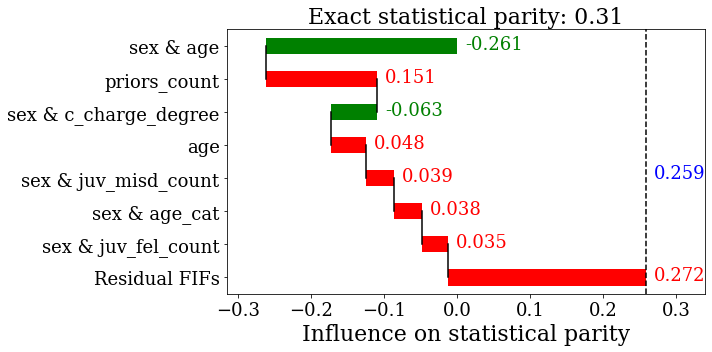

<Figure size 720x360 with 0 Axes>

In [10]:
plt = draw_plot(
    result, 
    draw_waterfall=True, 
    fontsize=22, 
    labelsize=18, 
    figure_size=(10, 5), 
    title="Exact statistical parity: {}".format(round(bias, 3)), 
    xlim=None,
    x_label="Influence on statistical parity", 
    text_x_pad=0.02, 
    text_y_pad=0.1, 
    result_x_pad=0.02, 
    result_y_location=0.5, 
    delete_zero_weights=False
    )
plt.show()
plt.clf()

### Explaining equalized odds

Next, we explain equalized odds, which belongs to separation group fairness metrics.

$$
\textbf{Equalized odds } = \max_{y \in [0, 1]}(\max_{\mathbf{a}} \Pr[\widehat{Y} = 1 | Y = y, \mathbf{A} = \mathbf{a}] - \min_{\mathbf{a}} \Pr[\widehat{Y} = 1 | Y = y, \mathbf{A} = \mathbf{a}])
$$

In [11]:
results, bias_values = explain_equalized_odds(
                    clf, 
                    X_train, 
                    y_train, # For equalized odds, we need to pass the true labels as well
                    sensitive_features=sensitive_features, 
                    maxorder=2,
                    spline_intervals=4,
                    verbose=False)
# Since there are two class labels, results and bias_values are lists of length 2

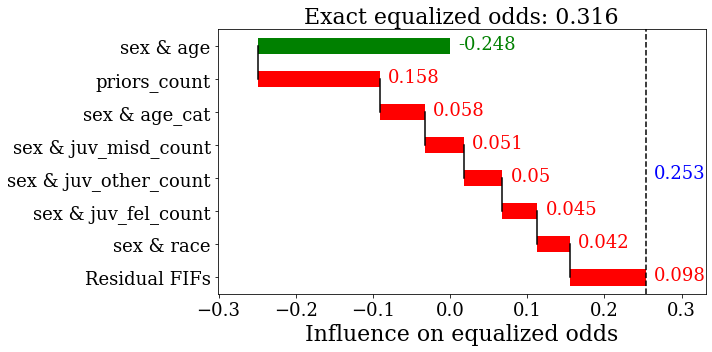

<Figure size 720x360 with 0 Axes>

In [12]:
index_max_unfairness = np.argmax(bias_values) # we choose the class label with the highest bias for equalized odds
plt = draw_plot(results[index_max_unfairness], 
                draw_waterfall=True, 
                fontsize=22, 
                labelsize=18, 
                figure_size=(10, 5), 
                title="Exact equalized odds: {}".format(round(bias_values[index_max_unfairness], 3)), 
                xlim=None,
                x_label="Influence on equalized odds", 
                text_x_pad=0.02, 
                text_y_pad=0.1, 
                result_x_pad=0.02, 
                result_y_location=0.5, 
                delete_zero_weights=False
)
plt.show()
plt.clf()

### Explaining predictive parity

Finally, we explain predictive parity, which belongs to sufficiency group fairness metrics.
$$
\textbf{Predictive parity } = \max_{y \in [0, 1]}(\max_{\mathbf{a}} \Pr[Y = 1 | \widehat{Y} = y, \mathbf{A} = \mathbf{a}] - \min_{\mathbf{a}} \Pr[Y = 1 | \widehat{Y} = y, \mathbf{A} = \mathbf{a}])
$$


In [13]:
results, bias_values = explain_predictive_parity(
            clf, 
            X_train, 
            y_train, # For predictive parity, we need to pass the true labels as well
            sensitive_features=sensitive_features, 
            maxorder=2, 
            spline_intervals=4,
            verbose=False)

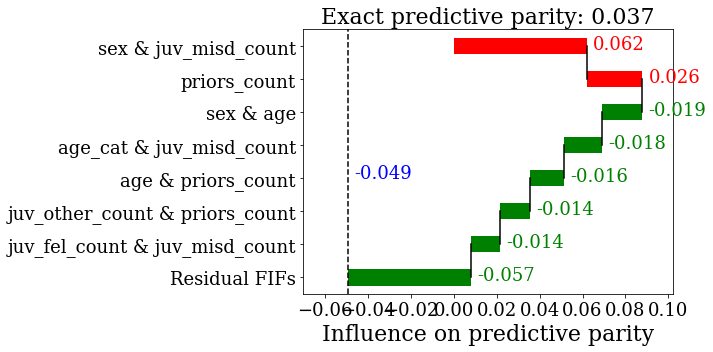

<Figure size 720x360 with 0 Axes>

In [14]:
index_max_unfairness = np.argmax(bias_values)
plt = draw_plot(results[index_max_unfairness],
                draw_waterfall=True,
                fontsize=22,
                labelsize=18,
                figure_size=(10, 5),
                title="Exact predictive parity: {}".format(round(bias_values[index_max_unfairness], 3)),
                xlim=None,
                x_label="Influence on predictive parity",
                text_x_pad=0.02,
                text_y_pad=0.1,
                result_x_pad=0.02,
                result_y_location=0.5,
                delete_zero_weights=False
)
plt.show()
plt.clf()


Reference:

[1] Ghosh, B., Basu, D., & Meel, K. S. (2022). How Biased are Your Features?: Computing Fairness Influence Functions with Global Sensitivity Analysis. arXiv preprint arXiv:2206.00667.